In [7]:
import torch
from src.models.gnn import GCNRegressor
import os
from tqdm import tqdm
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from generate_data import *

In [8]:
# Load the model
num_node_features = 2500
hidden_channels = 256
path = 'outputs/gcn_2_15_expanded/nn/best_val.pt'

model = GCNRegressor(num_node_features, hidden_channels)
model.load_state_dict(torch.load(path))
print(model)

GCNRegressor(
  (conv1): GCNConv(2500, 256)
  (conv2): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=1, bias=True)
)


In [9]:
def predict_curvature(model, data):
    # for each node in graph, create subgraph and pass through GCN
    # return tuple of (features, curvature, predicted curvature)
    subgraph_list = create_subgraphs(data)
    features = []
    curvatures = []
    predicted_curvatures = []

    for subgraph in subgraph_list:
        with torch.no_grad():
            pred = model(subgraph.x.float(), subgraph.edge_index, subgraph.edge_attr.float(), subgraph.batch)
            features.append(subgraph.x)
            curvatures.append(subgraph.y)
            predicted_curvatures.append(pred)
    return features, curvatures, predicted_curvatures
    
    
def create_subgraphs(full_graph, subgraph_k=1):
    subgraph_list = []
    for i in tqdm(range(full_graph.x.shape[0]), desc=f'Processing Graph'):
        subgraph_nodes, subgraph_edges, mapping, _ = k_hop_subgraph(i, subgraph_k, full_graph.edge_index.transpose(0,1).long(), relabel_nodes=True, directed=False)
        subgraph = Data(x=full_graph.x[subgraph_nodes], edge_index=subgraph_edges, edge_attr=full_graph.edge_attr[subgraph_edges[0]], y=full_graph.y[i])
        subgraph_list.append(subgraph)
    return subgraph_list

Creating torus dataset with 5000 nodes, inner radius 1, and outer radius 2
computed Rdist
computed density
computed nearest neighbor matrices


Processing Graph: 100%|██████████| 5000/5000 [00:02<00:00, 2120.84it/s]


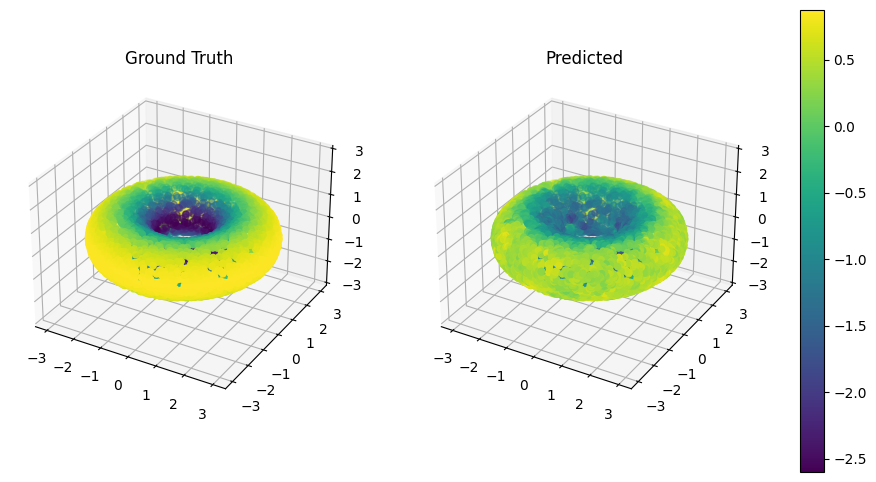

In [10]:
# # Plot the results for the torus

# # generate new data
N = 5000
k = 10
inner_radius = 1
outer_radius = 2
torus_data, X = create_torus_dataset(inner_radius, outer_radius, N, k)

# predict curvature
features, curvatures, predicted_curvatures = predict_curvature(model, torus_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# # plot results
# # create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())

Creating sphere dataset with 5000 nodes, dimension 2, and radius 1
computed Rdist
computed density
computed nearest neighbor matrices


Processing Graph: 100%|██████████| 5000/5000 [00:02<00:00, 2109.59it/s]


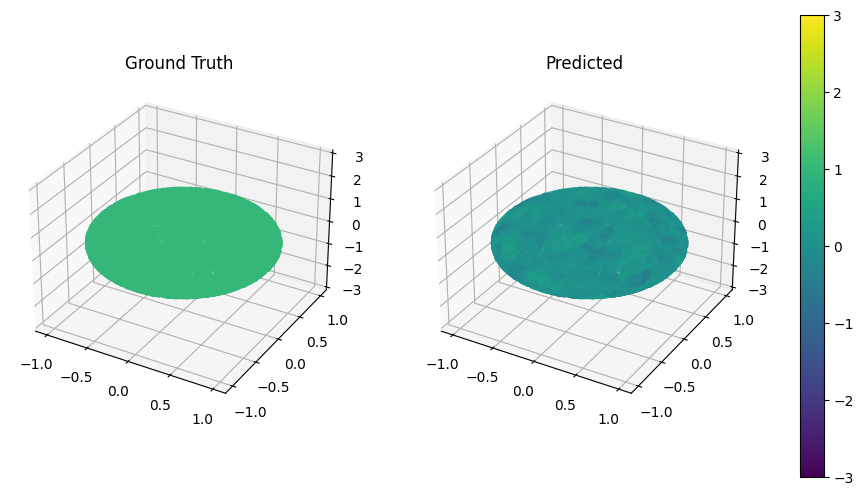

In [38]:
# Plot the results for the sphere

# generate new data
N = 5000
R = 1
sphere_data, X = create_sphere_dataset(R, N)
# predict curvature
features, curvatures, predicted_curvatures = predict_curvature(model, sphere_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
# create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)

p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist(), vmin=-3, vmax=3)
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist(), vmin=-3, vmax=3)
fig.colorbar(p2, ax=axs.ravel().tolist())

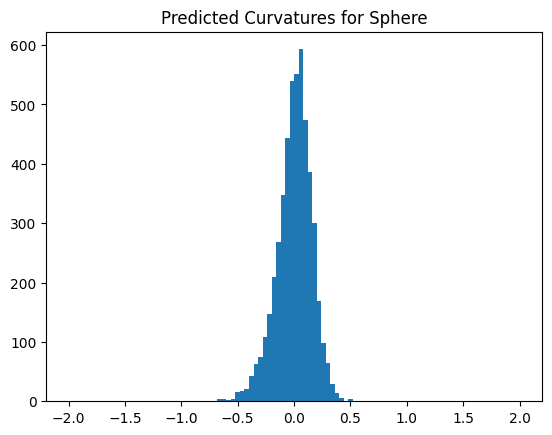

In [40]:
# plot histogram of predicted curvatures for sphere

plt.hist(predicted_curvatures, bins=100, range=(-2, 2))
plt.title('Predicted Curvatures for Sphere')
plt.show()


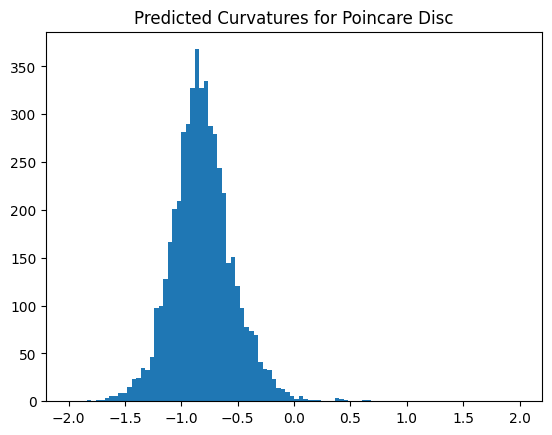

In [43]:
# generate data for poincare disk
N = 5000
k = 10
K = -1
Rh = 1
poincare_data, X = create_poincare_dataset(N, K, k, Rh)
# predict curvature
features, curvatures, predicted_curvatures = predict_curvature(model, poincare_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
plt.hist(predicted_curvatures, bins=100, range=(-2, 2))
plt.title('Predicted Curvatures for Poincare Disc')
plt.show()

Creating euclidean dataset with 5000 nodes, dimension 3, and radius 1
computed Rdist
computed density
computed nearest neighbor matrices


Processing Graph: 100%|██████████| 5000/5000 [00:02<00:00, 2176.64it/s]


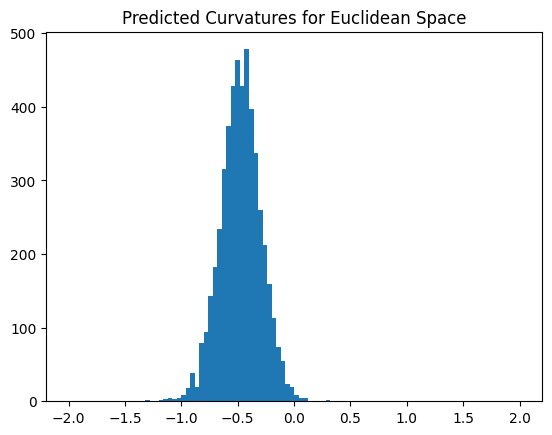

In [44]:
# generate euclidean data
N = 5000
d = 3
rad = 1
k = 10
euclidean_data, X = create_euclidean_dataset(N, d, rad, k)
# predict curvature
features, curvatures, predicted_curvatures = predict_curvature(model, euclidean_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
plt.hist(predicted_curvatures, bins=100, range=(-2, 2))
plt.title('Predicted Curvatures for Euclidean Space')
plt.show()

Creating hyperbolic dataset with 5000 nodes
computed Rdist
computed density
computed nearest neighbor matrices


Processing Graph: 100%|██████████| 5000/5000 [00:02<00:00, 2179.45it/s]


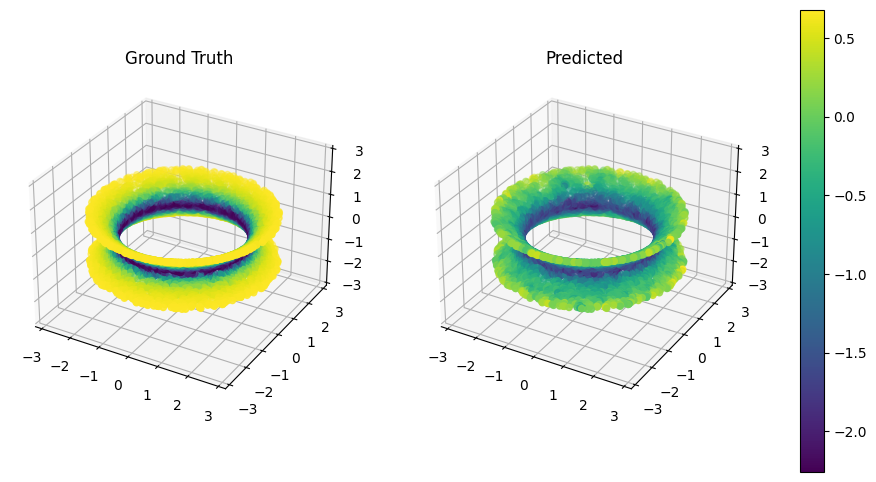

In [12]:
# Plot the results for the sphere

# generate new data
N = 5000
hyperboloid_data, X = create_hyperbolic_dataset(N)
# predict curvature
features, curvatures, predicted_curvatures = predict_curvature(model, hyperboloid_data)
curvatures = torch.cat(curvatures, dim=0).numpy()
predicted_curvatures = torch.cat(predicted_curvatures, dim=0).squeeze(-1).numpy()

# plot results
# create two adjacent 3d subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
axs[0].set_title('Ground Truth')
axs[1].set_title('Predicted')
axs[0].set_zlim(-3, 3)
axs[1].set_zlim(-3, 3)
p1 = axs[0].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=curvatures.tolist())
p2 = axs[1].scatter(X[:, 0], X[:, 1], X[:, 2], 'o', c=predicted_curvatures.tolist())
fig.colorbar(p2, ax=axs.ravel().tolist())